## Creating Regression Model:<br/>  to predict house sale price 

### Overview

**Objectives & Background**

As a data scientist my task here is to create a regression model based on the Ames Housing Dataset. This model will predict the price of a house at sale. The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It includes over 80 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. The Ames Housing is an increadible alternative for data scientists looking for a revamped version of the frequently used Boston Housing dataset.<br/> 

The Ames Housing dataset is used in the Advanced Regression Techniques challenge on the Kaggle website: https://www.kaggle.com/c/dsi-us-10-project-2-regression-challenge. My school, General Assembly is hosting a competition on Kaggle for the same topic which provides me an opportunity as a DSI student to use the platform for practicing advanced predictive modeling process and then refine models over time. 

**Requirements**
- Problem Statement & Data Analysis Plan
- Data Cleaning & EDA 
- Preprocessing and Modeling
- Conclusion and Recommendations 


-- Sumbissions --
 > - README.md 
 > - Technical Document: Jupyter notebook including analysis and models 
 > - At least one prediction Model submission on DSI-US-10 Regression Challenge 
 > - Presentation slides
 > - Data files
 
***Reference:***<br>
[DSI-US-10 Project_2 README](https://git.generalassemb.ly/DSI-US-10/project_2/blob/master/README.md)<br/>
[Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

### Importing Packages &  Load Data 

In [1]:
# importing all required packages for EDA, cleaning process and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries/packages required for Linear Regression and Modeling:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn import metrics

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
#define the file path to import the data
file_path = '../datasets/train.csv'
train = pd.read_csv(file_path)

### Data Cleaning and Exploring Data  Analysis:
Datasets Description: 
> * DataFrame (train.csv) includes 81 variables (columns) and 2051 rows listing residential properties sold in Ames, Iowa from 2006 to 2010. Data columns include 23 nominal, 23 ordinal, 15 discrete, and 20 continuous variables.<br>
   * Data types: float64(11 variables), int64(28 variables), object(42 variables)

In [3]:
train.dtypes

Id                int64
PID               int64
MS SubClass       int64
MS Zoning        object
Lot Frontage    float64
                 ...   
Misc Val          int64
Mo Sold           int64
Yr Sold           int64
Sale Type        object
SalePrice         int64
Length: 81, dtype: object

**Consistency:**<br>
Renaming all variables with lower case and getting rid of whitespace.

In [4]:
 # renaming columns
train.columns = [column_name.lower().replace(' ', '_') for 
                 column_name in train.columns] 

**Dealing with missing data:**<br>
As expected some incomplete values were observed which require enormouse time to detect and correct. To simplify data cleaning I would most likely narrow down the effort and select only variables that are relevent to our objectives along the process.

The bar chart below shows the sum of null/missing values (blank cells) for each data column. Further examination shows that null values don't necessary mean that the data is missing. Null value for most of these variables simply indicates that a house does not offer these features, for example NA for "Alley" or "Fence" means there is no Alley or house does not have a Fence. As a solution:

- For variables similar to the mentioned examples NA cells will be filled with "No 'Feature'"
- For other variables null values will be replaced with Mode or Median of the same column since the missing datasets are not significant.

In [5]:
# Explore DataFrame dimension(DF), 
train.shape # Loot at the dimension; variables & rows

(2051, 81)

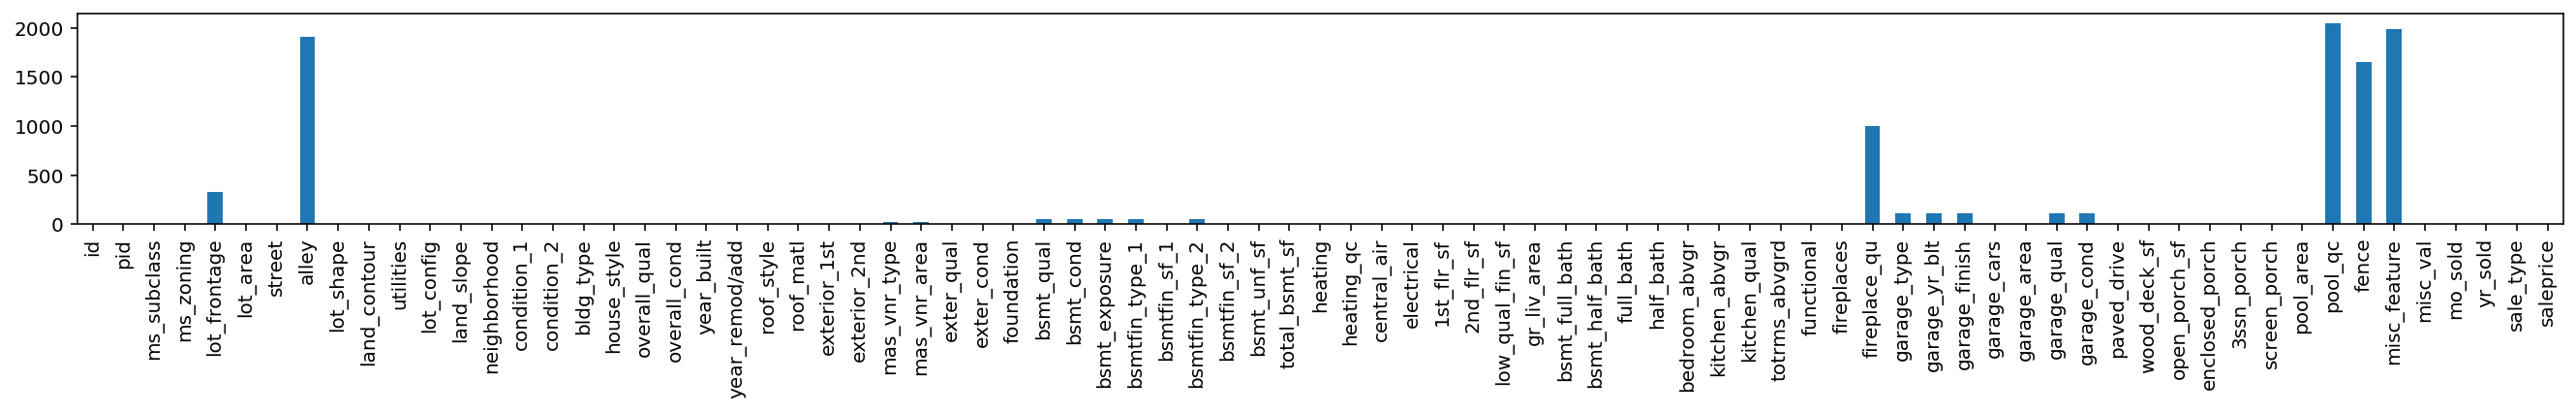

In [6]:
#plotting NaN values columns
train.isnull().sum().plot(kind = 'bar', figsize = (23,2)); 
plt.savefig('../plots/missingdata.png')

In [7]:
#filling null cells for when feature doesn't exist
train["alley"].fillna("No Alley", inplace = True) 
train["bsmt_qual"].fillna("No Basement", inplace = True)
train["bsmt_cond"].fillna("No Basement", inplace = True) 
train["bsmt_exposure"].fillna("No Basement", inplace = True) 
train["bsmtfin_type_1"].fillna("No Basement", inplace = True) 
train["bsmtfin_type_2"].fillna("No Basement", inplace = True)
train["fireplace_qu"].fillna("No Fireplace", inplace = True)
train["pool_qc"].fillna("No Pool", inplace = True)
train["fence"].fillna("No Fence", inplace = True)
train["misc_feature"].fillna("No Feature", inplace = True)
train["garage_type"].fillna("No Garage", inplace = True)
train["garage_yr_blt"].fillna("No Garage", inplace = True)
train["garage_finish"].fillna("No Garage", inplace = True)
train["garage_qual"].fillna("No Garage", inplace = True)
train["garage_cond"].fillna("No Garage", inplace = True)

In [8]:
#filling null values with median & mode 
train['mas_vnr_type'].describe() # looks into mode (top)
train['mas_vnr_type'].fillna("None", inplace = True)
train['mas_vnr_area'].fillna(train['mas_vnr_area'].median(), inplace = True)
train['lot_frontage'].fillna(train['lot_frontage'].median(), inplace = True)
train['garage_area'].fillna(train['garage_area'].median(), inplace = True)
train['total_bsmt_sf'].fillna(train['total_bsmt_sf'].median(), inplace = True)

**Further visibility on Categorical variables:**<br>
For the sake of simplicity and time, we need to decide which features are too important (have a high impact on price) prior to converting these features into numerical variable. For now I pause on this, as there are other similar directional features that can be used for our purpose.

In [9]:
train.dtypes[train.dtypes =='object'].head(30)

ms_zoning         object
street            object
alley             object
lot_shape         object
land_contour      object
utilities         object
lot_config        object
land_slope        object
neighborhood      object
condition_1       object
condition_2       object
bldg_type         object
house_style       object
roof_style        object
roof_matl         object
exterior_1st      object
exterior_2nd      object
mas_vnr_type      object
exter_qual        object
exter_cond        object
foundation        object
bsmt_qual         object
bsmt_cond         object
bsmt_exposure     object
bsmtfin_type_1    object
bsmtfin_type_2    object
heating           object
heating_qc        object
central_air       object
electrical        object
dtype: object

#### Identifying key metrics that actually matter:
When it comes to the property value, there are a number of key factors which determine house prices. According to  Opendoor (one of the largest online real-estate company) some of the key factors to consider when pricing a home are: historic sales price, quality of the neighborhood, the market, nearby features and the size, appeal, age and condition of the home. [Source](https://www.opendoor.com/w/blog/factors-that-influence-home-value)
                                   
I will be using the given information as base of hypothesis and use statistical diagrams to determine patterns and relationship between these factors (as independant variables) and their impact on property's sale price (as a dependant variable).<br>

To start, classifying variables under the above-mentioned factors, would make it easier to **clarify type of analysis required** and **identify meaningful attributes** that will be used for modeling process - 
  *Sale Price is considered as a dependant baseline, thus is not listed below:*<br>
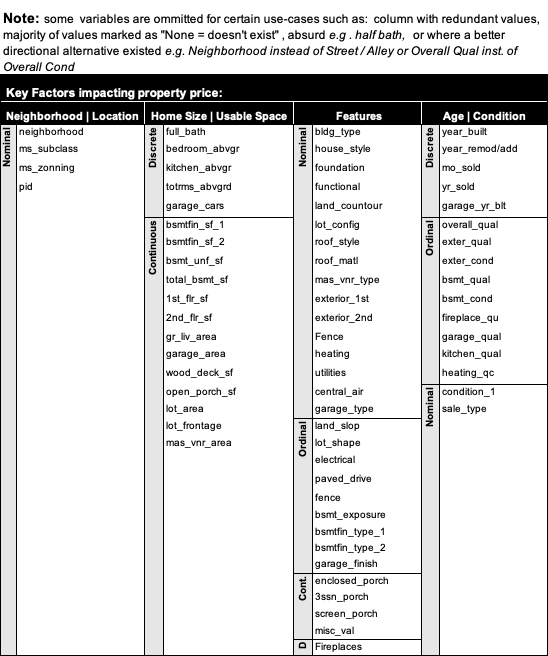
  

**Correlation with Sale Price | Distribution & Outliers** <br>

To measure the strenght of linear relationship between independant variables and sale price, looking into summary  of `correlation` and interpret:
- ~0 == no relationship 
- greater than 0 to 1 == positive to strong positive relationship 
- smallar than 0 to -1 == negative to strong negative relationship <br>

Again, to avoid high variance in model, my strategy here is to focus on attributes that show a linear correlation above 0.5 as listed below. 
*Note: According to National Association of Home Builders nearly 80% of real estate agents say fireplaces increase a home's value by anywhere from $$1,000 to $5,000'*, thus replacing mas_vnr_area with fireplaces. 

In [10]:
train.corr()['saleprice'].sort_values(ascending = False)
# selecting attributes with > 0.5 linear regression
train.corr()['saleprice'].sort_values(ascending = False).head(14)

saleprice         1.000000
overall_qual      0.800207
gr_liv_area       0.697038
garage_area       0.650241
garage_cars       0.648220
total_bsmt_sf     0.628754
1st_flr_sf        0.618486
year_built        0.571849
year_remod/add    0.550370
full_bath         0.537969
totrms_abvgrd     0.504014
mas_vnr_area      0.503579
fireplaces        0.471093
bsmtfin_sf_1      0.423519
Name: saleprice, dtype: float64

Using scatterplot to visualize the relationship between feature and price:

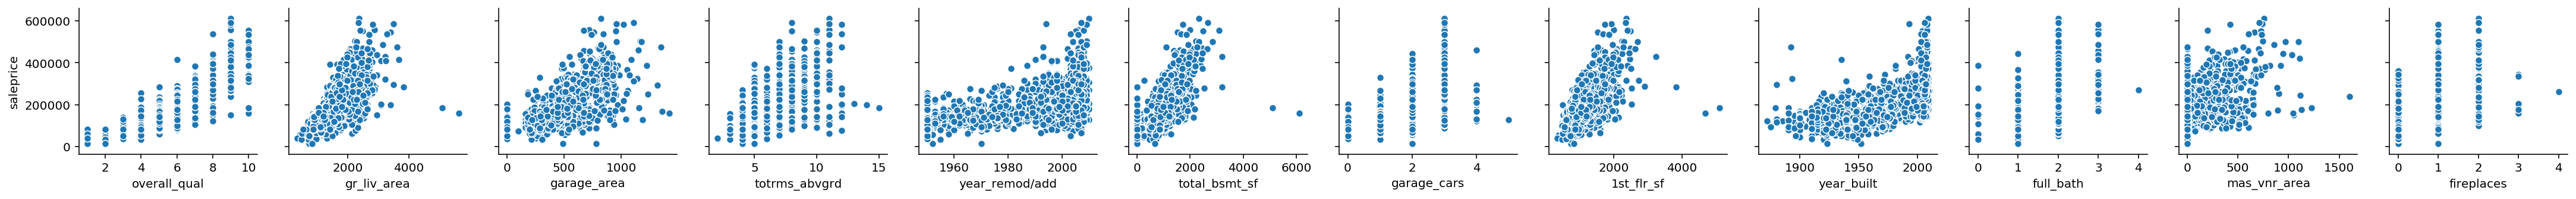

In [11]:
# Using pairplot method to create grouped scatterplots for easier comparison
sns.pairplot(train, y_vars = ['saleprice'],
x_vars = ['overall_qual', 'gr_liv_area','garage_area', 'totrms_abvgrd', 'year_remod/add', 
'total_bsmt_sf','garage_cars', '1st_flr_sf', 'year_built',
'full_bath',  'mas_vnr_area', 'fireplaces']);
plt.savefig('../plots/correlation.png')

Using histogram to verify frequency of data distribution and outliers for the selected features:


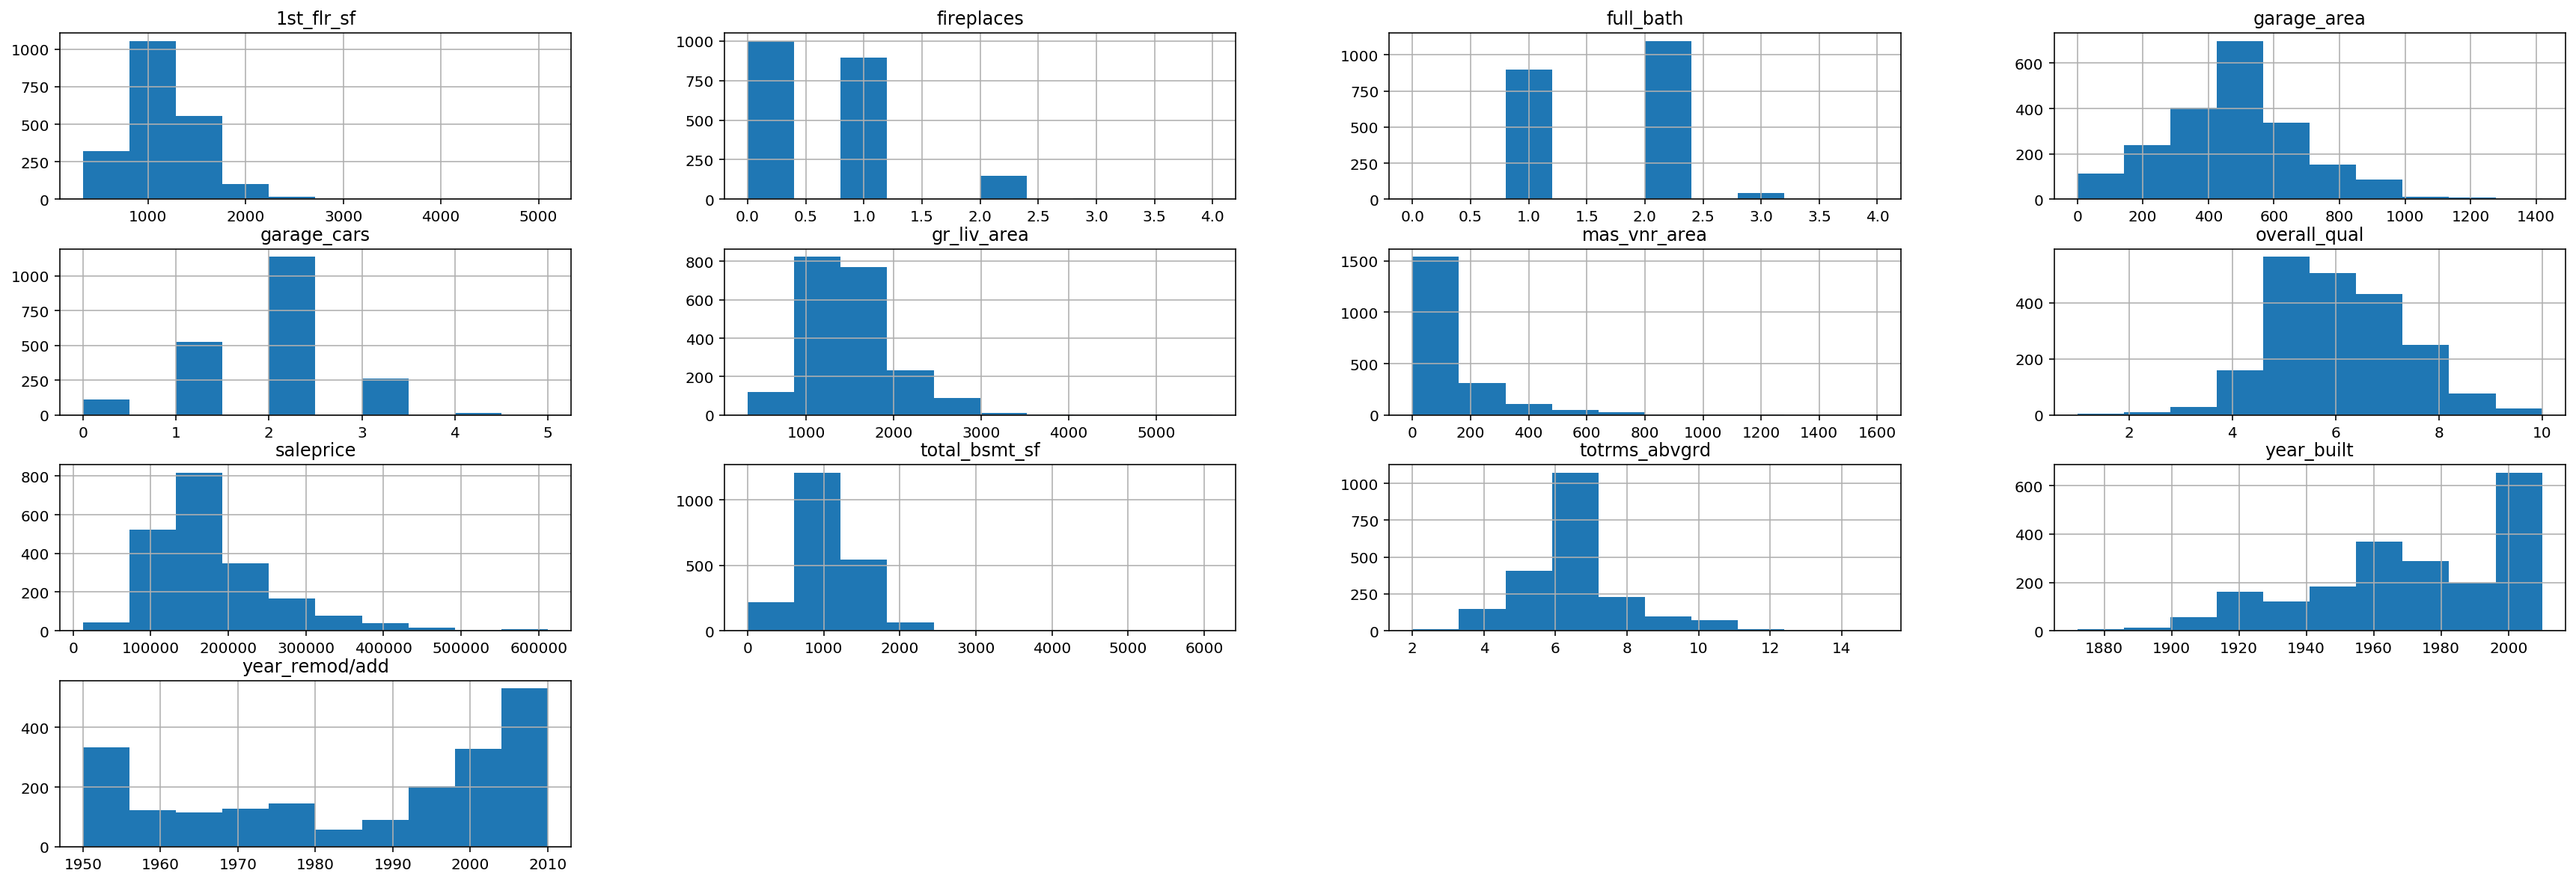

In [12]:
train.hist(['saleprice', 'overall_qual', 'gr_liv_area','garage_area', 'totrms_abvgrd', 'year_remod/add', 
'total_bsmt_sf','garage_cars', '1st_flr_sf', 'year_built',
'full_bath',  'mas_vnr_area', 'fireplaces'], figsize=(30, 10));
plt.savefig('../plots/distribution.png')

>**Key finding:** it appears that saleprice is severly right-skewed as majority of data values are concentrated near lower bound. It makes it difficult to generalize the typical value as there is no clear center point, thus we need to transform saleprice to get a normal dirtribution.

Log Transformation to nomalize distribution for sale_price:

In [13]:
# Log transform of target vector(Y)
train['log_price'] =np.log(train['saleprice'])